# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [138]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [139]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [140]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [141]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), img0_tuple[1], img1_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [142]:
train_folder = dset.ImageFolder(root=Config.training_dir)
print (train_folder)

Dataset ImageFolder
    Number of datapoints: 310
    Root location: ./data/faces/training/


In [143]:
train_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

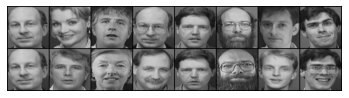

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]
[ 3 25  5  3 28 27 14 10]
[ 3  5 22 15 28 27 30 10]


In [144]:
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())
print(example_batch[3].numpy())
print(example_batch[4].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [145]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 64))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [214]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    
class SoftMax(torch.nn.Module):
  
    def __init__(self):
        super(SoftMax, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.CrossEntropyLoss()
        self.pred = []
       
        D_in = 128
        self.fc = torch.nn.Sequential(
        torch.nn.Linear(D_in, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 2))
       

    def forward(self, output1, output2, label):
#         print (output1.shape, output2.shape)
        concat = torch.cat((output1, output2),1)
#         print (concat.shape)
        self.pred = self.fc(concat)
        
#         print (pred.shape, label.squeeze().long().shape)

        current_loss = self.loss(self.pred, label.squeeze().long())

        return current_loss
    
    def calculate_prediction(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        return self.sigmoid(euclidean_distance)
        
    

## Training Time!

In [215]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [216]:
net = SiameseNetwork().cuda()
criterion = SoftMax().cuda()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [217]:
counter = []
loss_history, acc = [], [] 
iteration_number= 0

Epoch number 0
 Current loss 0.6855693459510803

Epoch number 1
 Current loss 0.6559138894081116

Epoch number 2
 Current loss 0.7246440649032593

Epoch number 3
 Current loss 0.7230684161186218

Epoch number 4
 Current loss 0.6187385320663452

Epoch number 5
 Current loss 0.5742013454437256

Epoch number 6
 Current loss 0.50191730260849

Epoch number 7
 Current loss 0.5036340951919556

Epoch number 8
 Current loss 0.4204525947570801

Epoch number 9
 Current loss 0.5690941214561462

Epoch number 10
 Current loss 0.5108872056007385

Epoch number 11
 Current loss 0.3663908839225769

Epoch number 12
 Current loss 0.411361962556839

Epoch number 13
 Current loss 0.3280280530452728

Epoch number 14
 Current loss 0.33432936668395996

Epoch number 15
 Current loss 0.3366907835006714

Epoch number 16
 Current loss 0.2675784230232239

Epoch number 17
 Current loss 0.24525663256645203

Epoch number 18
 Current loss 0.247873917222023

Epoch number 19
 Current loss 0.3751285672187805

Epoch number

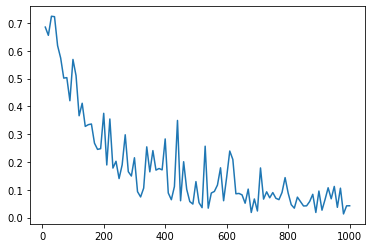

In [218]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label, _, _ = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
#         pred = criterion.calculate_prediction(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [219]:
# folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
# test_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transforms.Compose([transforms.Resize((100,100)),
#                                                                       transforms.ToTensor()
#                                                                       ])
#                                        ,should_invert=False)

# test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=2)
dataiter = iter(train_dataloader)
# x0,_,_,_,_ = next(dataiter)

for i in range(20):
    x0, x1, label2, qid, sid = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    loss = criterion(output1,output2,label2.cuda())
    
    pred = criterion.pred
    print(pred, label)
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()) + '; qid={}, sid={}'.format(qid.item(),sid.item()))
#     imshow(torchvision.utils.make_grid(concatenated), str(pred[:]) + '; qid={}, sid={}'.format(qid.item(),sid.item()))



tensor([[ 13.5694,  38.0109],
        [-33.2356,   3.4763]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[  2.6044,  13.5793],
        [-31.6688,   0.1343]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[0.],
      

In [205]:
def _dump_embeddings(feat1, q_id, s_id, same):
    # create embeddings for t-SNE tensorboard projector visualisation.
    # https://projector.tensorflow.org/ - append Q_id and Same as header for labels.tsv
    filename = 'viz/features_1030_f4_soft.tsv'
    filename_label = 'viz/labels_1030_f4_soft.tsv'
    with open(filename, 'a+') as embed_file, open(filename_label,'a+') as label_file:
        for i in range(feat1.shape[0]):
            embedding = feat1[i].squeeze().cpu().detach().numpy()
            embedding_str = ''.join(["{:.1f}".format(num) +'\t' for num in embedding])
            embed_file.write(embedding_str + '\n')
            label_file.write(str(q_id[i].cpu().detach().numpy())  + '\t' + str(s_id[i].cpu().detach().numpy())  + '\t' + str(same[i].cpu().detach().numpy()[0])+ '\n')

# save tsv files
train_dataloader = DataLoader(train_dataset,num_workers=6,batch_size=6,shuffle=True)
test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=6,shuffle=True)

for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label, q_id, s_id = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        output1,output2 = net(img0,img1)
        _dump_embeddings(output1, q_id+10, s_id+10, label)

for i, data in enumerate(test_dataloader, 0):
        img0, img1 , label, q_id, s_id = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        output1,output2 = net(img0,img1)
        _dump_embeddings(output1, q_id, s_id, label)
        

In [32]:
print(folder_dataset_test)

Dataset ImageFolder
    Number of datapoints: 90
    Root location: ./data/faces/testing/
